# Train an image classifier on the NACTI subset

We'll use the fantastic fastai library as much as possible, especially for the actual hard parts (esp. training and creating the "dataloaders").

In [1]:
# from utils import *
from fastai.vision.all import *
from utils import load_json
from collections import defaultdict, Counter

In [2]:
DATA = Path("/home/rory/data")
NACTI = DATA / "nacti"
NACTI_ANNOS = NACTI / "metadata.json"

Links:
- [NACTI dataset on LILA](https://lila.science/datasets/nacti)
- [COCO data format](https://cocodataset.org/#format-data)
- [COCO Camera Trap data format](https://github.com/Microsoft/CameraTraps/blob/master/data_management/README.md#coco-cameratraps-format)

Notes:
- I've moved images that failed `verify_image()` to `NACTI/bad_imgs`
    - Said images' original paths are stored in `NACTI/bad_image_files.txt`
- I've moved images for quail, turkeys, and unidentified deer to `NACTI/bad_imgs/[class]`
- I'm missing `empty` images

# ETL

First, let's take a peek at the directory structure to remind ourselves what's what.

In [3]:
list(NACTI.ls())

[Path('/home/rory/data/nacti/models'),
 Path('/home/rory/data/nacti/backups'),
 Path('/home/rory/data/nacti/imgs'),
 Path('/home/rory/data/nacti/bad_imgs'),
 Path('/home/rory/data/nacti/bad_paths-empty.txt'),
 Path('/home/rory/data/nacti/metadata.json'),
 Path('/home/rory/data/nacti/metadata.json.zip'),
 Path('/home/rory/data/nacti/downloads'),
 Path('/home/rory/data/nacti/lila_sas_urls.txt'),
 Path('/home/rory/data/nacti/bad_img_files.txt'),
 Path('/home/rory/data/nacti/urls_to_download-empty.txt'),
 Path('/home/rory/data/nacti/2021-12-13-1830_cats6_err036')]

In [4]:
list((NACTI/"imgs").ls())

[Path('/home/rory/data/nacti/imgs/part0'),
 Path('/home/rory/data/nacti/imgs/part1'),
 Path('/home/rory/data/nacti/imgs/part3'),
 Path('/home/rory/data/nacti/imgs/part2')]

Next, let's make a helper function to grab the COCO-style annos and return the list of filenames and the corresponding list of labels.

In [6]:
def get_nacti_annos(path, cats=None, prefix=None):
    """
    Open a NACTI json in `path` and returns the lists of filenames (with
    maybe `prefix`). Unlike COCO, NACTI labels are single-label.
    Returns fns, lbls.
    """
    cct = load_json(path)
    id2img, id2lbl = {}, defaultdict(None)
    id2cat = {o['id']:o['common name'] for o in cct['categories']}
    
    # populate id2lbl
    for o in cct['annotations']:
        lbl = id2cat[o['category_id']]
        if cats == None:
            id2lbl[o['image_id']] = lbl
        else:
            if lbl in cats:
                id2lbl[o['image_id']] = lbl
    
    # populate id2img
    id2img = {o['id'] : ifnone(prefix,'') + o['file_name']
              for o in cct['images'] if o['id'] in id2lbl}
    
    # iterate through IDs to return img and annos
    ids = list(id2img.keys())
    return [id2img[i] for i in ids], [id2lbl[i] for i in ids]

I had to write another helper to rearrange my images so that they matched the initial stucture they were downloaded in. Don't mess with the directory structures!

In [7]:
def organize_image_files(img_dir=NACTI/"imgs"):
    
    # make name2path: map from name to correct path given by the annos json
    fns, lbls = get_nacti_annos(NACTI/"metadata.json")
    names = L(fns).map(lambda fn: fn.split("/")[2])
    name2path = {f:NACTI/"imgs"/p for f,p in zip(names, fns)}
    
    # get paths to image files
    imgs = get_image_files(img_dir)
    
    # move each image to its correct path
    exceptions = []
    for i,img in enumerate(imgs):
        if i%1000==0: print(i)
            
        name = img.name
        new_path = name2path[name]
        new_parent = new_path.parent
        
        try: os.makedirs(new_parent)
        except: pass

        try: shutil.move(img, name2path[name])
        except Exception as e: exceptions.append(e)

    return exceptions

Now we can use `get_nacti_annos` to get our image files and labels.

In [8]:
fns, lbls = get_nacti_annos(NACTI/"metadata.json")
len(fns), fns[:3] , lbls[:3]

(3382215,
 ['part0/sub000/2010_Unit150_Ivan097_img0001.jpg',
  'part0/sub000/2010_Unit150_Ivan097_img0002.jpg',
  'part0/sub000/2010_Unit150_Ivan097_img0003.jpg'],
 ['red deer', 'red deer', 'red deer'])

In [9]:
fns = L(fns).map(lambda f: f.split("/")[-1])
fns[:3]

(#3) ['2010_Unit150_Ivan097_img0001.jpg','2010_Unit150_Ivan097_img0002.jpg','2010_Unit150_Ivan097_img0003.jpg']

In [10]:
paths = get_image_files(NACTI/"imgs")
len(paths), paths[:3]

(256931,
 (#3) [Path('/home/rory/data/nacti/imgs/part0/sub028/2016_Unit074_Ivan092_img5521.jpg'),Path('/home/rory/data/nacti/imgs/part0/sub028/2016_Unit074_Ivan092_img4468.jpg'),Path('/home/rory/data/nacti/imgs/part0/sub028/2016_Unit074_Ivan092_img4886.jpg')])

In [11]:
fn2lbl = {fn:lbl for fn,lbl in zip(fns,lbls)}
labels = paths.map(lambda p: fn2lbl[p.name])
labels

(#256931) ['mule deer','mule deer','mule deer','mule deer','american black bear','mule deer','mule deer','mule deer','mule deer','mule deer'...]

In [12]:
Counter(labels).most_common()

[('mule deer', 85360),
 ('empty', 54983),
 ('california ground squirrel', 33685),
 ('american black bear', 28678),
 ('vehicle', 25973),
 ('cougar', 14684),
 ('unidentified deer', 7668),
 ('wild turkey', 3636),
 ('california quail', 2264)]

In [13]:
deer = [p for p in paths if fn2lbl[p.name] == 'mule deer']
squirrel = [p for p in paths if fn2lbl[p.name] == 'california ground squirrel']
bear = [p for p in paths if fn2lbl[p.name] == 'american black bear']
vehicle = [p for p in paths if fn2lbl[p.name] == 'vehicle']
cougar = [p for p in paths if fn2lbl[p.name] == 'cougar']
quail = [p for p in paths if fn2lbl[p.name] == 'california quail']
turkey = [p for p in paths if fn2lbl[p.name] == 'wild turkey']
unidentified_deer = [p for p in paths if fn2lbl[p.name] == 'unidentified deer']
empty = [p for p in paths if fn2lbl[p.name] == 'empty']

For the first model, I'm only using a few categories to speed the development loop up.

In [14]:
my_cats = [deer, squirrel, bear, cougar, empty]

I'm going to limit the number of images while balancing the classes (which isn't always necessary in deep learning) to further restrict the size of my dataset to speed up the dev cycle.

In [24]:
max_items = 1_000
subset = L()

for my_cat in my_cats:
    subset += L(my_cat).shuffle()[:max_items]

len(subset)

5000

I'll make sure I only have the labels for images in my subset, too.

In [25]:
subset_labels = subset.map(lambda p: fn2lbl[p.name])

# Dataloaders & Training

Time to use fastai to further format the data and train the model.

In [26]:
dls = ImageDataLoaders.from_lists(
    NACTI,
    subset,
    subset_labels,
    item_tfms=Resize(400),
    batch_tfms=[*aug_transforms(size=256, max_zoom=1.0)],
    bs=64
)

Let's check out some training images:

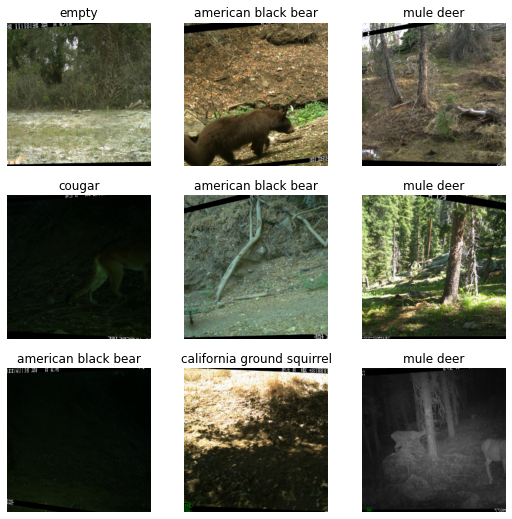

In [27]:
dls.show_batch()

We can now create and train a deep learning model (I'm choosing resnet18 to match the model that's described in the NACTI whitepaper).

In [28]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

We use lr_find to automatically select our learning rate.

/home/rory/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


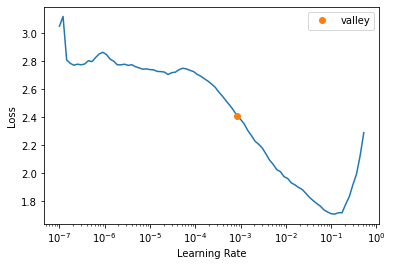

In [22]:
lr = learn.lr_find()

Now we "fine tune" the model, aka train a pretrained model (in order to save us from having to do a ton of computation). The pretrained model was trained using the ImageNet dataset.

In [29]:
learn.fine_tune(5, lr.valley)

For fun, here's the result of training a resnet34 model using the entire subset for 10 epochs. The error rate starts approaching a low enough value that seems like it should be good enough for a production system!

In [37]:
# learn.fine_tune(10, 1e-3) # lr.valley seems to always be approx 1e-3

We're now going to export the model to be used on our trailcam images. (Please excuse my poor choice of filename).

In [31]:
learn.export("2021-12-13-1830_cats6_err036")

# Inference

In [32]:
from fastai.vision.all import *
from utils import *

In [33]:
inf = load_learner(NACTI/"2021-12-13-1830_cats6_err036")

In [34]:
vocab = inf.dls.vocab
vocab

['american black bear', 'california ground squirrel', 'cougar', 'empty', 'mule deer', 'vehicle']

In [35]:
test_deer = get_targs(['deer'])
test_bear = get_targs(['bear'])
test_vehicle = get_targs(['truck'])
test_squirrel = get_targs(['squirrel'])

Found 63 test records for categories ['deer'].
Found 6 test records for categories ['bear'].
Found 51 test records for categories ['truck'].
Found 13 test records for categories ['squirrel'].


In [36]:
i=-1

/home/rory/data/trailcam/1637240616_SYFW0803.jpg
american black bear : 0.0
california ground squirrel : 0.0
cougar : 0.0
empty : 0.0
mule deer : 1.0
vehicle : 0.0


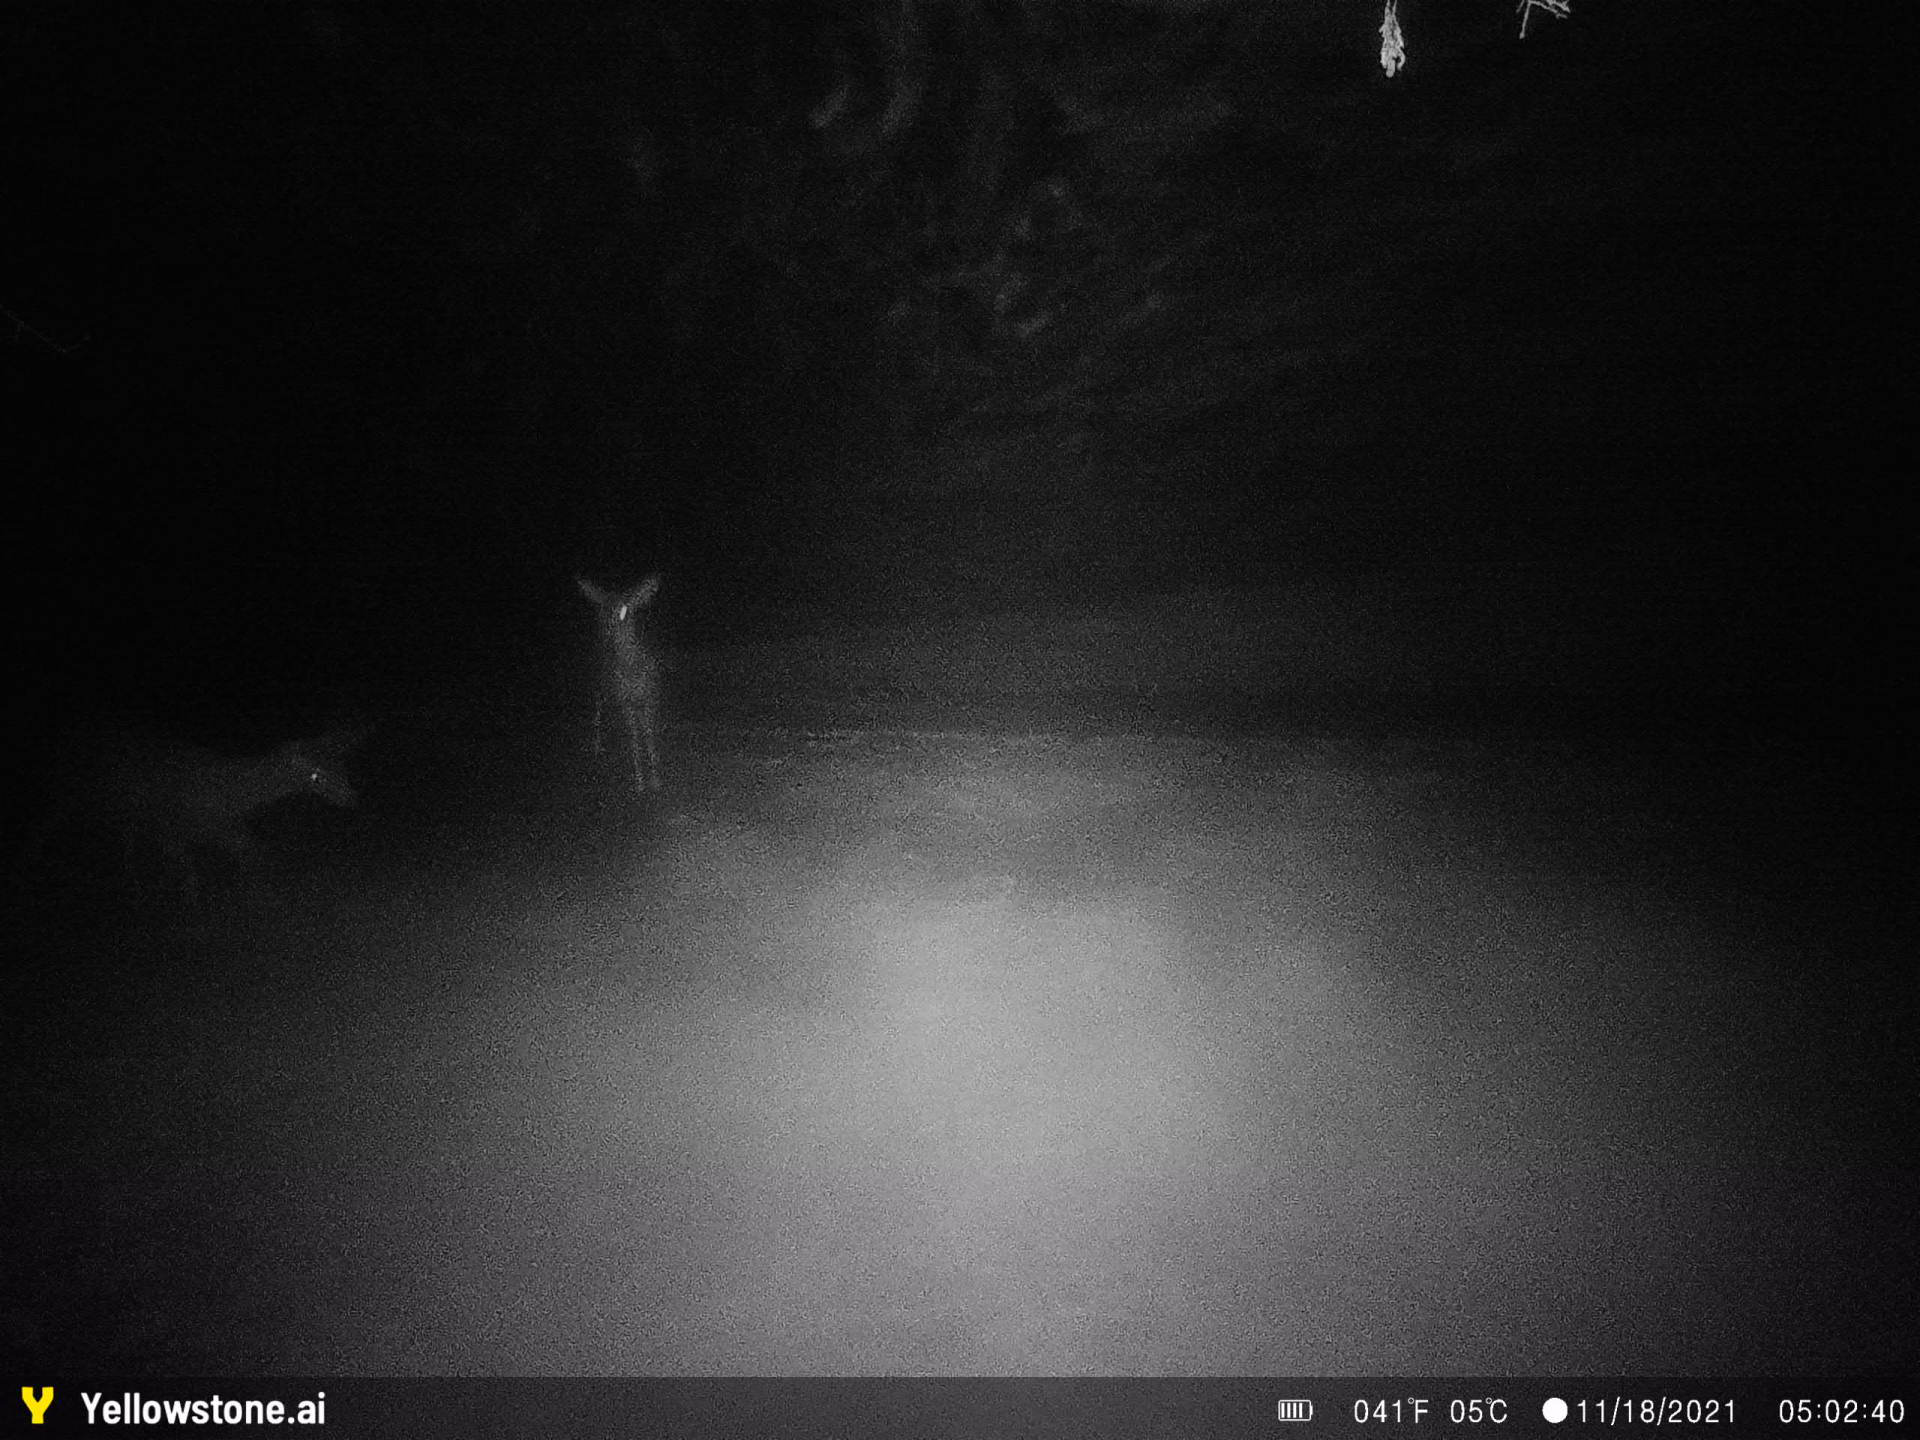

In [39]:
i+=1
path = test_deer[i]['path']
pred_lbl, conf_idx, confs = inf.predict(path)
pred_conf = round(confs[conf_idx].item(), 2)
print(path)
for v,c in zip(vocab,confs): print(v, ":", round(c.item(), 2))
load_image(path)

In [40]:
deer_preds = L(test_deer).map(lambda d: inf.predict(d['path']))

In [41]:
deer_preds

(#63) [('cougar', tensor(2), tensor([2.9027e-03, 2.1736e-01, 6.7997e-01, 4.0138e-04, 9.8627e-02, 7.3871e-04])),('cougar', tensor(2), tensor([0.0136, 0.0360, 0.5217, 0.0010, 0.4233, 0.0044])),('mule deer', tensor(4), tensor([1.1496e-03, 5.3415e-05, 6.4426e-05, 7.3438e-07, 9.9872e-01, 6.8523e-06])),('mule deer', tensor(4), tensor([6.6141e-05, 1.6623e-06, 2.4814e-05, 7.1332e-08, 9.9990e-01, 2.2618e-06])),('mule deer', tensor(4), tensor([1.2064e-02, 5.0096e-03, 5.3897e-03, 2.1806e-04, 9.6750e-01, 9.8185e-03])),('cougar', tensor(2), tensor([8.8323e-04, 2.3443e-04, 6.8737e-01, 1.1222e-06, 3.0859e-01, 2.9265e-03])),('american black bear', tensor(0), tensor([8.6269e-01, 1.5245e-04, 5.7120e-03, 1.3176e-03, 1.2338e-01, 6.7476e-03])),('empty', tensor(3), tensor([0.2498, 0.1746, 0.0692, 0.3652, 0.0610, 0.0802])),('vehicle', tensor(5), tensor([0.0634, 0.0192, 0.0061, 0.1623, 0.0022, 0.7468])),('vehicle', tensor(5), tensor([0.0012, 0.0593, 0.0043, 0.3717, 0.0897, 0.4737]))...]

In [42]:
Counter(deer_preds.map(lambda p: p[0])).most_common()

[('mule deer', 30),
 ('vehicle', 19),
 ('empty', 8),
 ('cougar', 5),
 ('american black bear', 1)]

That's 30/63 = 48% accuracy, which is far less than what we were lead to believe when training the model. The reason for that is that camera trap models are never as accurate for "out of sample" data (meaning pictures from new locations). The models are only good at classifying images from locations its seen before.

Let's take a look at some predictions to see if we can find a theme.

In [43]:
i=-1

/home/rory/data/trailcam/1637279060_SYFW0857.jpg
vehicle (0.75)


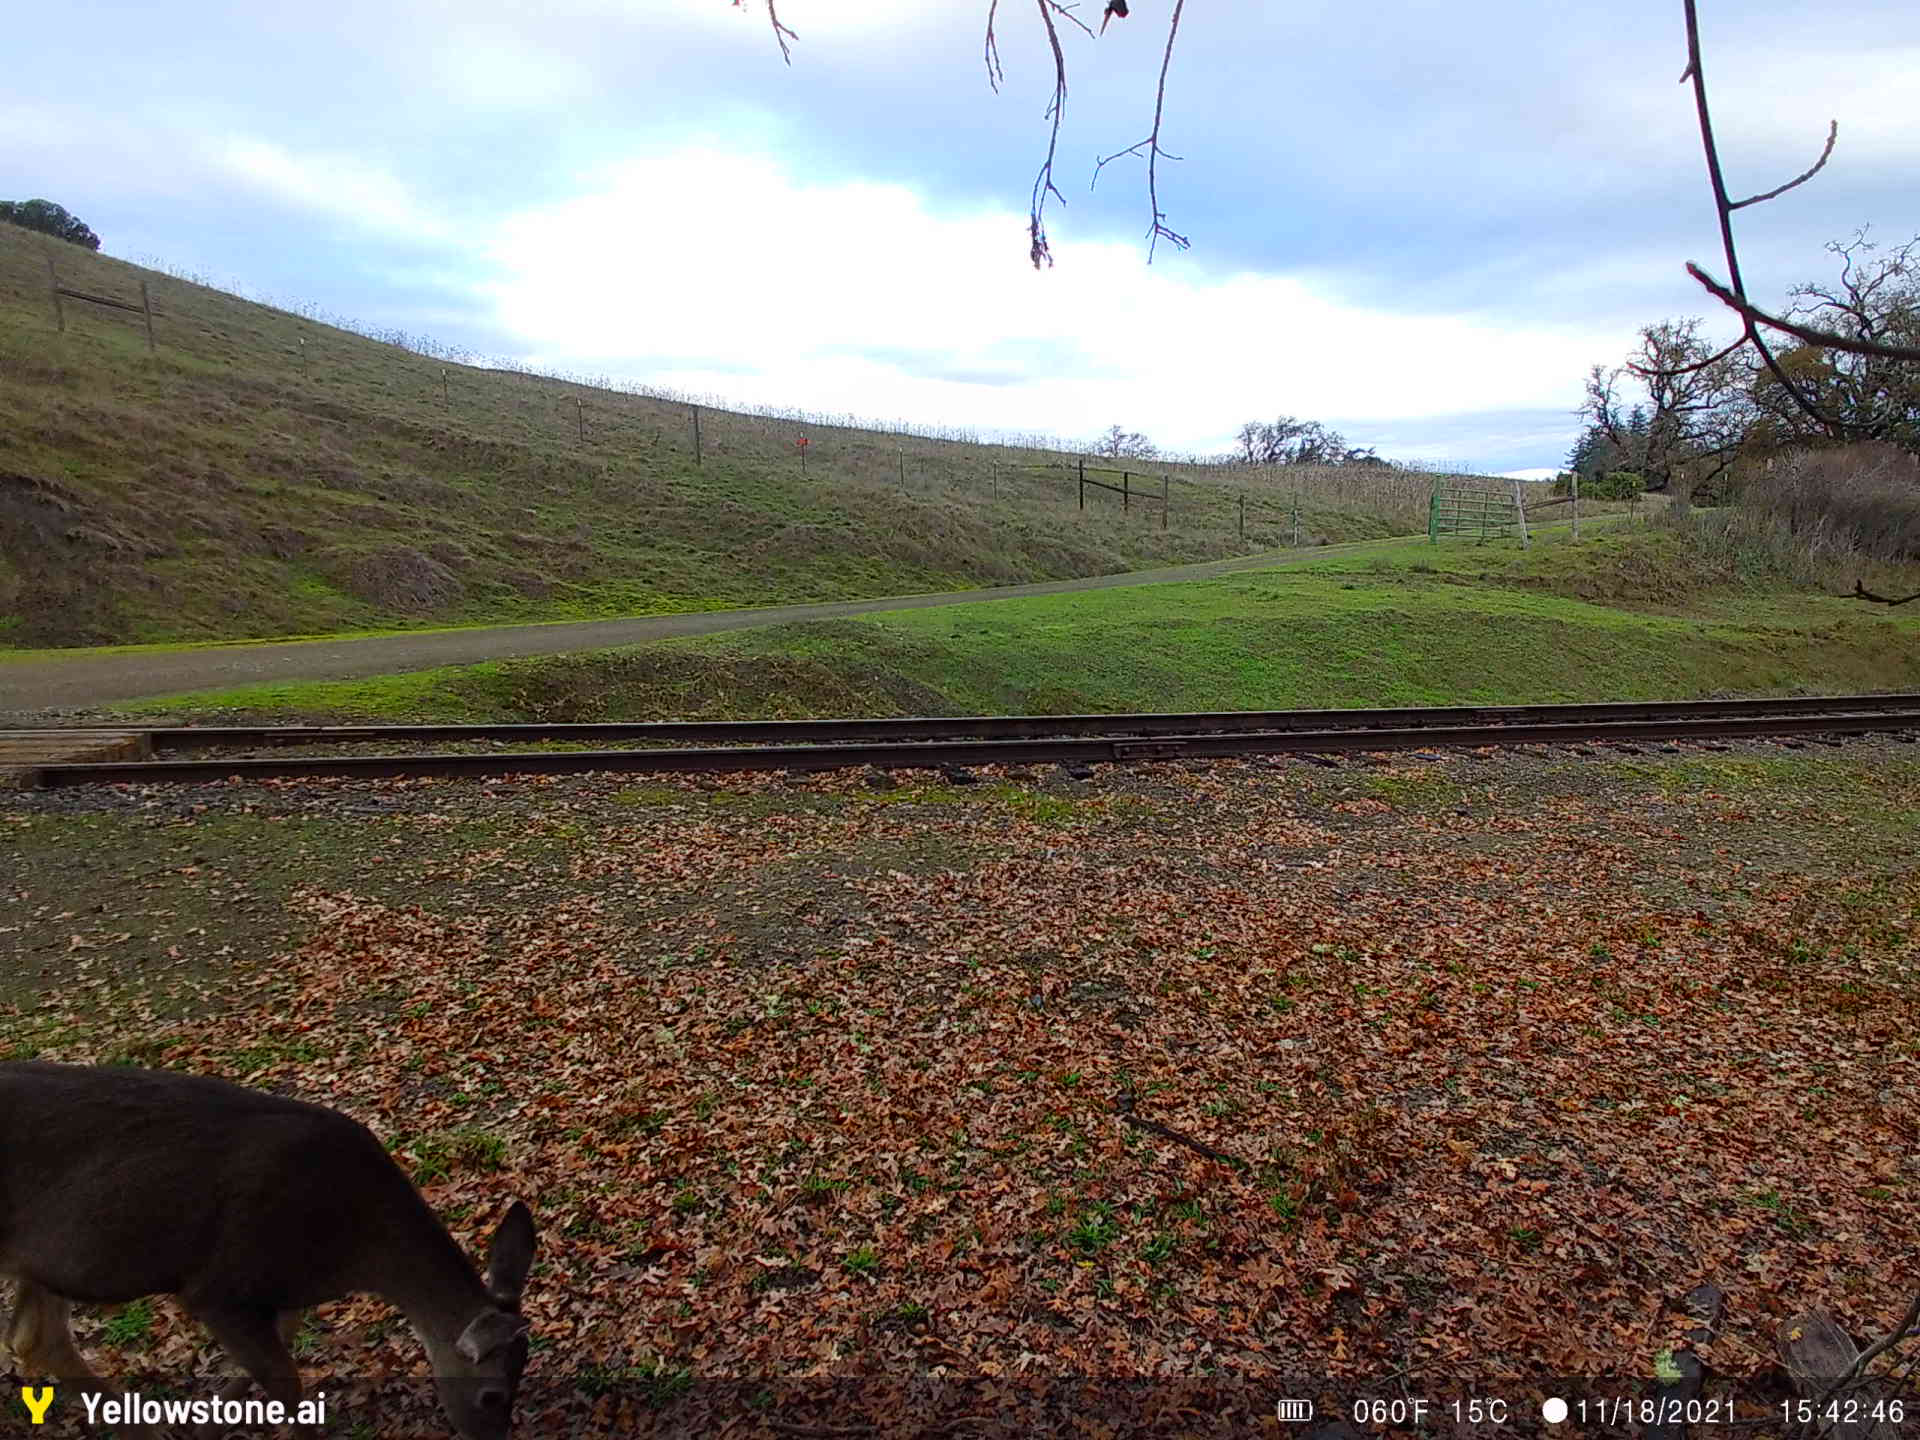

In [52]:
i+=1
path = test_deer[i]['path']
pred_lbl, conf_idx, confs = inf.predict(path)
pred_conf = round(confs[conf_idx].item(), 2)
print(path)
print(f"{pred_lbl} ({pred_conf})")
load_image(path)

After looking through the images, here's what stood out to me:
- The model was getting the images of deer at night mostly correct. When it was wrong, it was wrong randomly.
- The model was failing to identify images of deer during the day and labeled most of them as "vehicle".
- The images are from a location where both a train track and a dirt road are visible during only the day.

Based on those three points, I believe that the model is seeing the tracks and the road and assuming that the image has a vehicle in it. This is a perfect example of what we mean by a model performing poorly on "out of sample" images.

# Next step: pre-process images with bounding boxes

If I were to improve my predictions further, I'd do the following:
- Train a bounding box model to identify 'vehicle', 'person', and 'animal' to crop each image to specific regions of interest.
- Retrain this classification model for animal labels only using the cropped bounding boxes instead of the entire images.

The above approach seems to have worked well for others and is how the camera trap team at Microsoft built their MegaDetection bounding box model for trailcams. It's actually a common approach to pre-processing image data in many machine learning pipelines.

This notebook by the Microsoft camera trap team shows how to use their pretrained MegaDetection model on any images uploaded to Google Drive: [Megadetector_Colab_test.ipynb](https://colab.research.google.com/github/microsoft/CameraTraps/blob/master/detection/megadetector_colab.ipynb#scrollTo=s5uwmpmaTZMX) (link goes to a Colab notebook).